# RBA Selected Tables

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up" data-toc-modified-id="Set-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set-Up</a></span><ul class="toc-item"><li><span><a href="#Some-useful-constants" data-toc-modified-id="Some-useful-constants-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some useful constants</a></span></li><li><span><a href="#List-available-data-tables-...-if-needed" data-toc-modified-id="List-available-data-tables-...-if-needed-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>List available data tables ... if needed</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Watermark</a></span></li></ul></li><li><span><a href="#Monetary-Policy---Official-Cash-Rate" data-toc-modified-id="Monetary-Policy---Official-Cash-Rate-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Monetary Policy - Official Cash Rate</a></span></li><li><span><a href="#Australian-interbank-interest-rates" data-toc-modified-id="Australian-interbank-interest-rates-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Australian interbank interest rates</a></span></li><li><span><a href="#Australian-Government-Bonds---daily-rates" data-toc-modified-id="Australian-Government-Bonds---daily-rates-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Australian Government Bonds - daily rates</a></span></li><li><span><a href="#Velocity-of-money" data-toc-modified-id="Velocity-of-money-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Velocity of money</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Watermark</a></span></li></ul></div>

## Set-Up

In [1]:
# usual data science imports
import pandas as pd
import matplotlib.pyplot as plt

# syste imports
from pathlib import Path

# local imports
import rba_common
import abs_common
from finalise_plot import finalise_plot

### Some useful constants

In [2]:
# multi-time-period charts
RECENCY_PERIOD = 5 # years
TODAY = pd.Timestamp('today')
RECENT = TODAY - pd.DateOffset(years=RECENCY_PERIOD)

V_RECENCY_PERIOD = 275 # days
V_RECENT = TODAY - pd.DateOffset(days=V_RECENCY_PERIOD)

# Where to put the charts
CHART_DIR = "./charts/RBA"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)

# plotting stuff
plt.style.use('fivethirtyeight')
SOURCE = "Source: RBA"

### List available data tables ... if needed

In [3]:
if False: 
    rba_common.get_data_table_labels()

## Monetary Policy - Official Cash Rate

In [4]:
# get the data
a2 = rba_common.get_data('Monetary Policy Changes – A2')
a2_meta, a2_data = a2 if a2 is not None else (None, None)

Using cached data for "Monetary Policy Changes – A2"


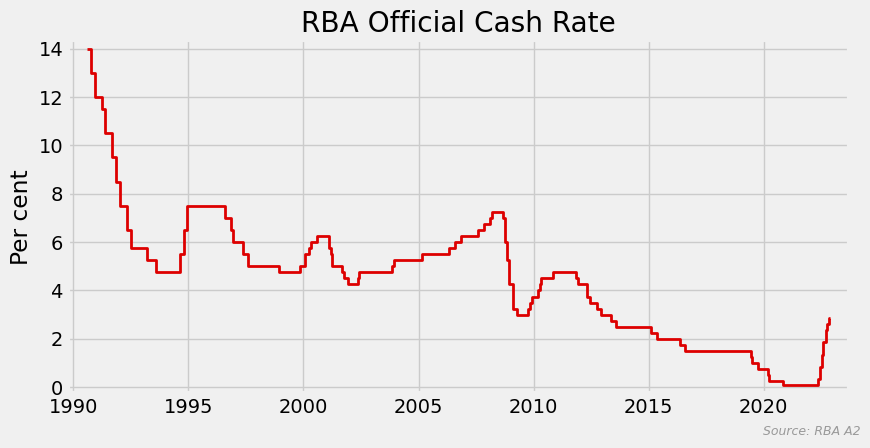

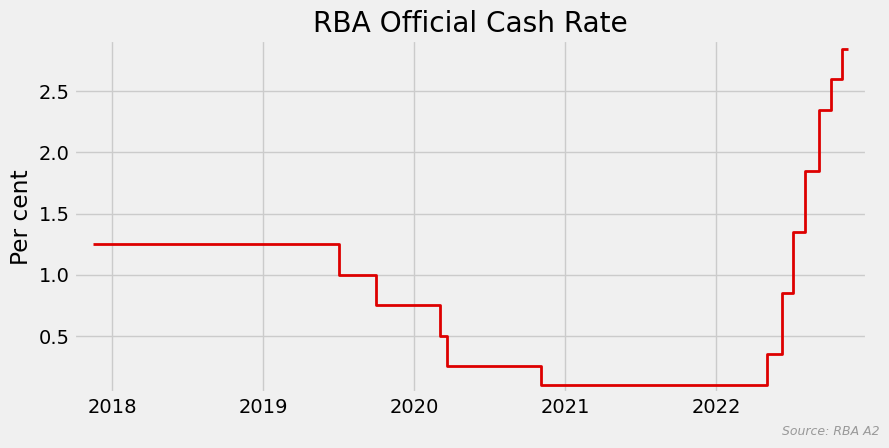

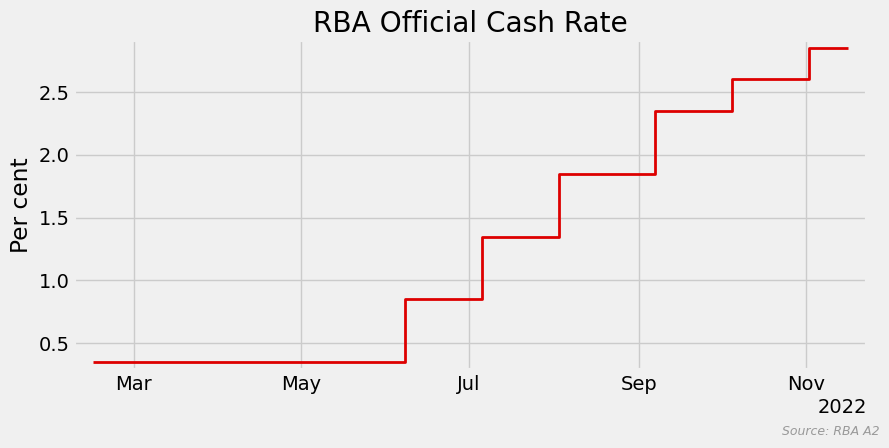

In [5]:
# extract the cash rate series
target = 'New Cash Rate Target'
series_id = a2_meta[a2_meta.Title == target].index[0]
series = a2_data[series_id]

# remove some early target ranges
series = series[series.index >= pd.Timestamp("1990-08-02")].astype(float)

# update the series to today
if TODAY > series.index[-1]:
    last = series.iloc[-1]
    series[TODAY] = last
    series = series.sort_index()
                        
# plot full series and recent
count=0
for start in None, RECENT, V_RECENT:
    # get data and filename-tag
    data = series if start is None else series[series.index >= start].copy()
    tag = "" if start is None else f'-recent{count}'
    if start is not None and start < data.index[0]:
        data[start] = data.iloc[0]
        data = data.sort_index()
    count += 1
        
    # plot
    ax = data.plot(drawstyle='steps-post', c='#dd0000', lw=2)
    ax.margins(0.025, 0.025)
    title = "RBA Official Cash Rate"
    finalise_plot(
        ax, title, "Per cent", tag, CHART_DIR,
        rfooter=f'{SOURCE} A2',
        concise_dates=True,
        show=True,
    )

## Australian interbank interest rates

In [6]:
# get the dataset
_ = rba_common.get_data('Interest Rates and Yields – Money Market – Daily – F1')
f1_meta, f1_data = _ if _ is not None else (None, None)

Using cached data for "Interest Rates and Yields – Money Market – Daily – F1"


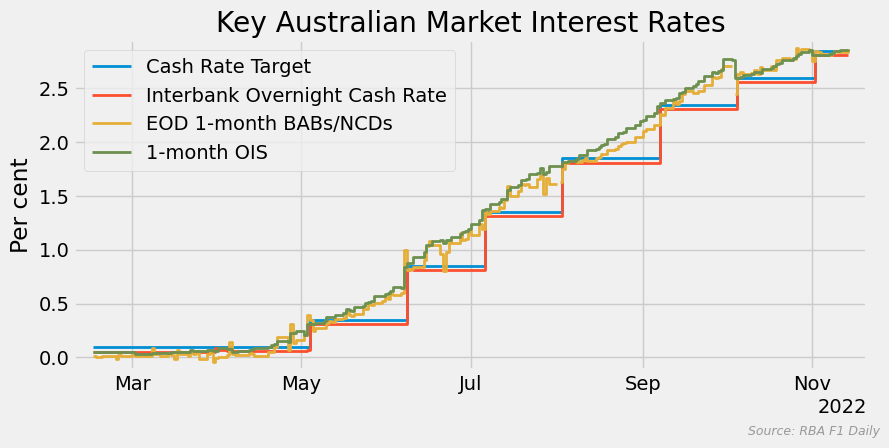

In [7]:
# get the specific data we want, for the very recent past
wanted = ['Cash Rate Target',
          'Interbank Overnight Cash Rate',
          'EOD 1-month BABs/NCDs',
          '1-month OIS',
          '1-month Treasury Note',]
series_ids = [f1_meta[f1_meta.Title == x].index[0] for x in wanted]
plotable_data = (
    f1_data[series_ids]
    .pipe(lambda x: x[x.index>=V_RECENT])
    .rename({old:neu for old, neu in zip(series_ids, wanted)}, axis=1)
    .dropna(how='all', axis=1)
    .dropna(how='all', axis=0)
)

# And plot
ax = plotable_data.plot(drawstyle='steps-post', lw=2)
ax.margins(0.025, 0.025)
title = "Key Australian Market Interest Rates"
ax.legend(title=None, loc='best')

finalise_plot(
    ax, title, "Per cent", "", CHART_DIR,
    rfooter=f'{SOURCE} F1 Daily',
    concise_dates=True,
    show=True,
)

## Australian Government Bonds - daily rates

In [8]:
# get the dataset
_ = rba_common.get_data('Capital Market Yields – Government Bonds – Daily – F2')
f2_meta, f2_data = _ if _ is not None else (None, None)
#f2_meta

Using cached data for "Capital Market Yields – Government Bonds – Daily – F2"


In [9]:
# get the specific data we want
plotable = f2_meta[f2_meta.Title.str.contains('Australian') &
                   f2_meta.Title.str.contains('year') ]
plotable_labels = (
    plotable
    .Title
    .str.replace('Australian Government ', '')
)
plotable_data = f2_data[plotable_labels.index]
plotable_data.columns = plotable_labels

# plot full series and recent
count = 0
for start in None, RECENT, V_RECENT:
    # get data and filename-tag
    data = plotable_data if start is None else plotable_data[plotable_data.index >= start].copy()
    tag = "" if start is None else f'-recent{count}'
    lw = 2 if start == V_RECENT else 1
    count += 1
        
    # plot
    ax = data.plot(drawstyle='steps-post', lw=lw)
    ax.margins(0.025, 0.025)
    title = "Capital Market Yields - Australian Government Bonds"
    
    # remove legend title
    #handles, labels = ax.get_legend_handles_labels()
    ax.legend(title=None, loc='best')
    
    # finalise
    finalise_plot(
        ax, title, "Per cent per annum", tag, CHART_DIR,
        rfooter=f'{SOURCE} F2 Daily',
        concise_dates=True,
        #show=True,
    )    

## Velocity of money

In [ ]:
abs_dict = get_ABS_meta_and_data(catalogue_id)


## Watermark

In [10]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed Nov 16 2022 08:14:09

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.6.0

pandas    : 1.5.1
matplotlib: 3.6.2

Watermark: 2.3.1

